<a href="https://colab.research.google.com/github/syedtihaamahmad/MYMchatbot/blob/main/MYMchatbotipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting my personal Google drive for dataset and other util files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nltk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Implementation of text preprocessing techniques such as stemming, tokenization and embedding so to prepare dataset for our NLP model.

In [ ]:
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def tokenize(sentence):
    """
    split sentence into array of words/tokens
    a token can be a word or punctuation character, or number
    """
    return nltk.word_tokenize(sentence)


def stem(word):
    """
    stemming = find the root form of the word
    """
    return stemmer.stem(word.lower())


def bag_of_words(tokenized_sentence, words):
    """
    Embedding of words into numbers.
    """
    # stem each word
    sentence_words = [stem(word) for word in tokenized_sentence]
    # initialize bag with 0 for each word
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words: 
            bag[idx] = 1

    return bag

Defining a simple Linear model

In [ ]:
import torch
import torch.nn as nn


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

Training script for our model

In [ ]:
import numpy as np
import random
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#from nltk_utils import bag_of_words, tokenize, stem
#from model import NeuralNet

with open('/content/drive/MyDrive/intents.json', 'r') as f:
    intents = json.load(f)

all_words = []
tags = []
xy = []
# loop through each sentence in our intents patterns
for intent in intents['intents']:
    tag = intent['tag']
    # add to tag list
    tags.append(tag)
    for pattern in intent['patterns']:
        # tokenize each word in the sentence
        w = tokenize(pattern)
        # add to our words list
        all_words.extend(w)
        # add to xy pair
        xy.append((w, tag))

# stem and lower each word
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# remove duplicates and sort
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(all_words), "unique stemmed words:", all_words)

# create training data
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    # X: bag of words for each pattern_sentence
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    # y: PyTorch CrossEntropyLoss needs only class labels, not one-hot
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Hyper-parameters 
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(words)
        # if y would be one-hot, we must apply
        # labels = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')

29 patterns
7 tags: ['case_studies', 'contact', 'goodbye', 'greeting', 'partnership', 'pricing', 'services']
71 unique stemmed words: ["'s", 'a', 'about', 'address', 'agenc', 'an', 'ani', 'are', 'bye', 'can', 'care', 'case', 'client', 'collabor', 'contact', 'cost', 'day', 'discount', 'do', 'email', 'exampl', 'get', 'give', 'good', 'goodby', 'greet', 'have', 'hello', 'hey', 'hi', 'how', 'i', 'idea', 'in', 'inform', 'later', 'me', 'meet', 'much', 'notabl', 'of', 'offer', 'open', 'option', 'other', 'partnership', 'price', 'provid', 'rate', 'schedul', 'see', 'servic', 'show', 'some', 'stori', 'studi', 'success', 'take', 'team', 'tell', 'there', 'to', 'togeth', 'touch', 'we', 'what', 'white-label', 'with', 'work', 'you', 'your']
71 7
Epoch [100/1000], Loss: 0.8025
Epoch [200/1000], Loss: 0.3371
Epoch [300/1000], Loss: 0.0237
Epoch [400/1000], Loss: 0.1714
Epoch [500/1000], Loss: 0.0072
Epoch [600/1000], Loss: 0.0338
Epoch [700/1000], Loss: 0.0151
Epoch [800/1000], Loss: 0.0016
Epoch [900/10

Inference function for our model :

In [ ]:
def customchatbot(sentence,all_words):

    sentence = tokenize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() > 0.65:
        for intent in intents['intents']:
            if tag == intent["tag"]:
                print(f"{bot_name}: {random.choice(intent['responses'])}")
                rsentence = bot_name + ":" + random.choice(intent['responses'])
    else:
        print(f"{bot_name}: I do not understand...")
        rsentence= bot_name + ": I do not understand..."
    return rsentence

In [ ]:
import random
import json

import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('/content/drive/MyDrive/intents.json', 'r') as json_data:
    intents = json.load(json_data)

FILE = "data.pth"
data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data['all_words']
tags = data['tags']
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

bot_name = "MYM"
print("Let's chat! (type 'quit' to exit)")
while True:
    sentence = input("You: ")
    if sentence == "quit":
        break
    customchatbot(sentence,all_words)


Let's chat! (type 'quit' to exit)
You: hi
MYM: Hey! What brings you here today?
You: how are you
MYM: I do not understand...
You: Can we work together
MYM: We believe in the power of collaboration and are open to partnership opportunities. Let's connect and explore how we can work together.
You: What are your pricing options
MYM: Our pricing varies depending on the specific services and scope of the project. It would be best to discuss your requirements with our team for a personalized quote.
You: show me a case study
MYM: Certainly! We have several case studies showcasing our successful marketing campaigns. Please visit our website to explore our portfolio.
You: Any more examples
MYM: Absolutely! Our case studies demonstrate the positive impact of our marketing strategies. Feel free to check them out on our website for inspiration.
You: okay. Goddbye
MYM: Hello! How can I assist you today?
You: goodbye
MYM: See you later! Take care!
You: quit


We also deploy our model on a local host URL using Flask.

In [ ]:
from flask import Flask, render_template, request
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

#Flask initialisation
app = Flask(__name__,template_folder='/content/drive/MyDrive/templates',static_folder='/content/drive/MyDrive/templates/CSS')


@app.route("/")
def index():
	return render_template("index.html")
@app.route("/get", methods=["GET","POST"])
def chatbot_response():
	msg = request.form["msg"]
	response = customchatbot(msg,all_words)
	return response

if __name__ == "__main__":
    app.run()


https://pjj9s907vx-496ff2e9c6d22116-5000-colab.googleusercontent.com/
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [23/May/2023 20:52:17] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/May/2023 20:52:17] "GET /CSS/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/May/2023 20:52:17] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/May/2023 20:52:21] "POST /get HTTP/1.1" 200 -


MYM: Hi there! How may I help you?


INFO:werkzeug:127.0.0.1 - - [23/May/2023 20:52:30] "POST /get HTTP/1.1" 200 -


MYM: We offer customized pricing based on your specific needs and goals. Please contact us for a detailed discussion and a tailored quote.


INFO:werkzeug:127.0.0.1 - - [23/May/2023 20:52:46] "POST /get HTTP/1.1" 200 -


MYM: For any inquiries or to schedule a meeting, please email us at [email protected] We will get back to you promptly.


INFO:werkzeug:127.0.0.1 - - [23/May/2023 20:52:59] "POST /get HTTP/1.1" 200 -


MYM: Goodbye! Have a great day!


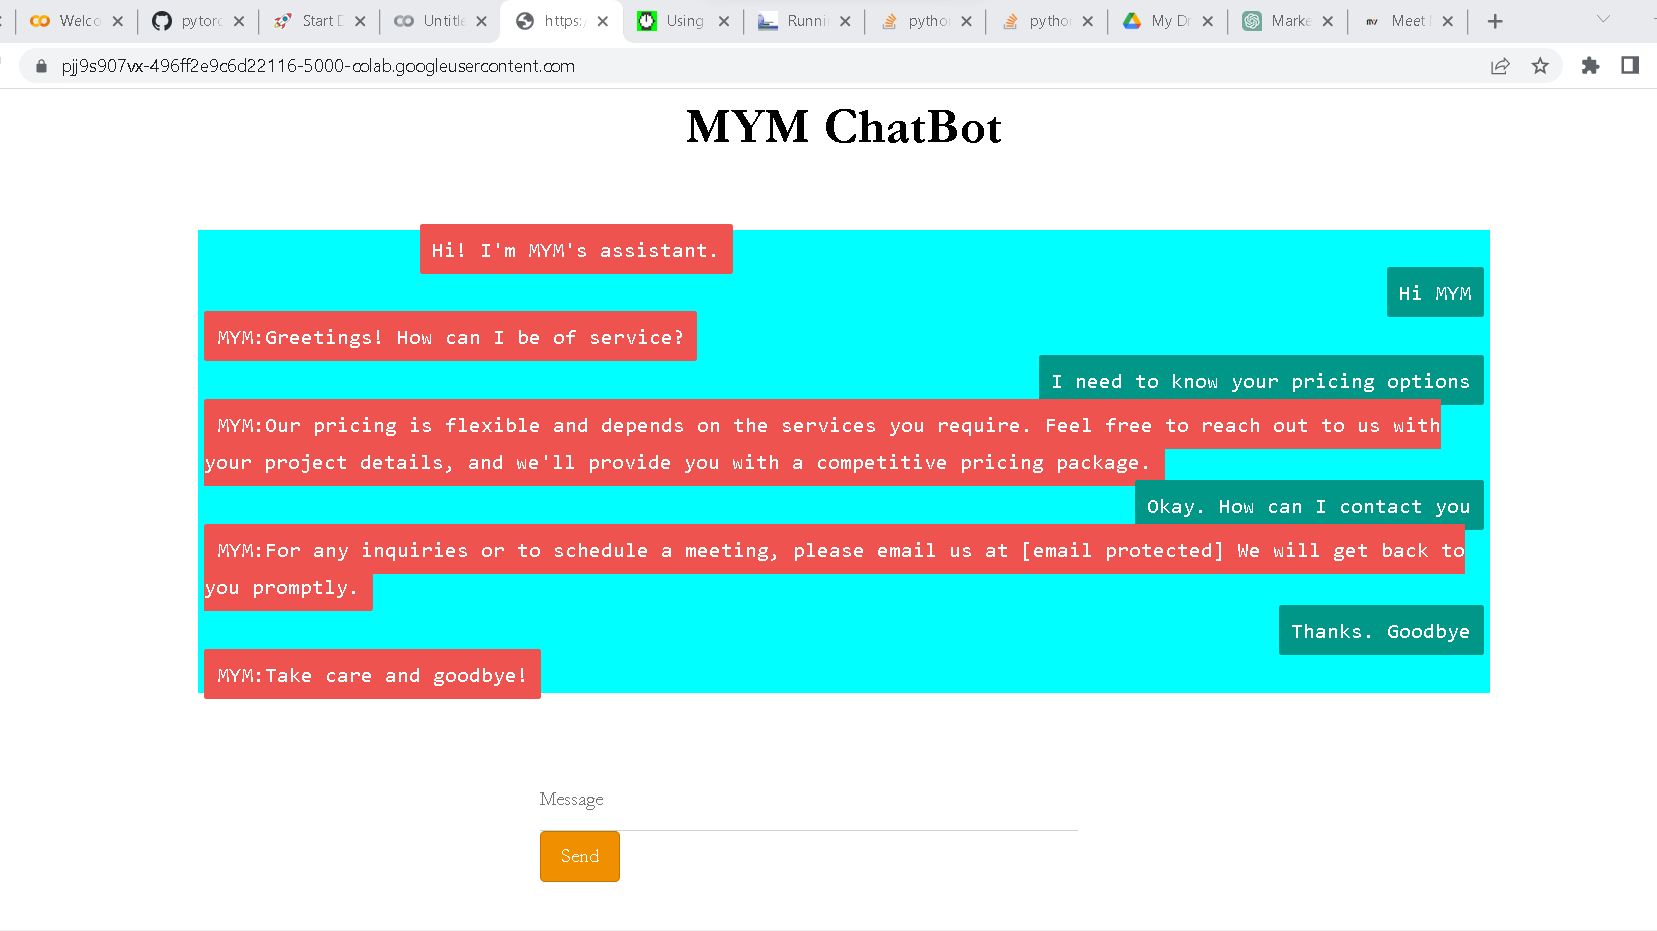